In [1]:
import torch
import gpytorch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import os

# Load Data

In [2]:
merced_boundary = [-120.55, 37.38, -120.39, 37.21]
h = 0.005
lons = np.arange(merced_boundary[0], merced_boundary[2], h)
lats = np.arange(merced_boundary[3], merced_boundary[1], h)

In [3]:
def check_in_box(lon, lat, box):
    return lon >= box[0] and lon <= box[2] and lat >= box[1] and lat <= box[3]

data_dir = "../data/Jan1524_Jan2224/"
data_files = [file for file in os.listdir(data_dir) if file.endswith(".csv")]
time_idx = 420
data_grid = {(lon, lat, lon+h, lat+h): [] for lon in lons for lat in lats}
for file in data_files:
    df = pd.read_csv(data_dir + file)
    record = df.loc[time_idx, ['pm25', 'longitude', 'latitude']].to_numpy().astype(np.float64)
    pm, lon, lat = record[0], record[1], record[2]
    for box in data_grid.keys():
        if check_in_box(lon, lat, box):
            data_grid[box].append(pm)

for box, pms in data_grid.items():
    if len(pms) > 0:
        data_grid[box] = np.mean(pms)
    else:
        data_grid[box] = None

In [4]:
# Prepare training and test data for GP
train_x = []
train_y = []
test_x = []
for box in data_grid.keys():
    test_x.append([box[0], box[1]])
    if data_grid[box] is not None:
        train_x.append([box[0], box[1]])
        train_y.append(data_grid[box])
train_x = torch.tensor(train_x)
train_y = torch.tensor(train_y)
test_x = torch.tensor(test_x)
print("Shape of train_x: ", train_x.shape)
print("Shape of train_y: ", train_y.shape)
print("Shape of test_x: ", test_x.shape)

Shape of train_x:  torch.Size([7, 2])
Shape of train_y:  torch.Size([7])
Shape of test_x:  torch.Size([1120, 2])


# Construct GP model

In [5]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel()
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [6]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)
training_iter = 20000
model.train()
likelihood.train()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

In [7]:
for i in range(training_iter):
    model.train()
    likelihood.train()
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    if i % 500 == 0:
        print("Iter %d/%d - Loss: %.3f" % (i + 1, training_iter, loss.item()))
    optimizer.step()

Iter 1/20000 - Loss: 49.075
Iter 501/20000 - Loss: 11.192
Iter 1001/20000 - Loss: 7.185
Iter 1501/20000 - Loss: 5.460
Iter 2001/20000 - Loss: 4.472
Iter 2501/20000 - Loss: 3.844
Iter 3001/20000 - Loss: 3.432
Iter 3501/20000 - Loss: 3.165
Iter 4001/20000 - Loss: 2.999
Iter 4501/20000 - Loss: 2.903
Iter 5001/20000 - Loss: 2.852
Iter 5501/20000 - Loss: 2.826
Iter 6001/20000 - Loss: 2.661
Iter 6501/20000 - Loss: 2.656
Iter 7001/20000 - Loss: 2.651
Iter 7501/20000 - Loss: 2.644
Iter 8001/20000 - Loss: 2.637
Iter 8501/20000 - Loss: 2.627
Iter 9001/20000 - Loss: 2.614
Iter 9501/20000 - Loss: 2.593
Iter 10001/20000 - Loss: 2.555
Iter 10501/20000 - Loss: 2.525
Iter 11001/20000 - Loss: 2.514
Iter 11501/20000 - Loss: 2.509
Iter 12001/20000 - Loss: 2.506
Iter 12501/20000 - Loss: 2.505
Iter 13001/20000 - Loss: 2.505
Iter 13501/20000 - Loss: 2.505
Iter 14001/20000 - Loss: 2.505
Iter 14501/20000 - Loss: 2.505
Iter 15001/20000 - Loss: 2.505
Iter 15501/20000 - Loss: 2.505
Iter 16001/20000 - Loss: 2.505

# Prediction and Visualization

In [237]:
model.eval()
likelihood.eval()
pred_y = model(test_x)
pred_y_mean = pred_y.mean.detach().numpy()
pred_y_std = pred_y.stddev.detach().numpy()
pred_y_mean = pred_y_mean.reshape((len(lons), len(lats))).transpose()
pred_y_std = pred_y_std.reshape((len(lons), len(lats))).transpose()

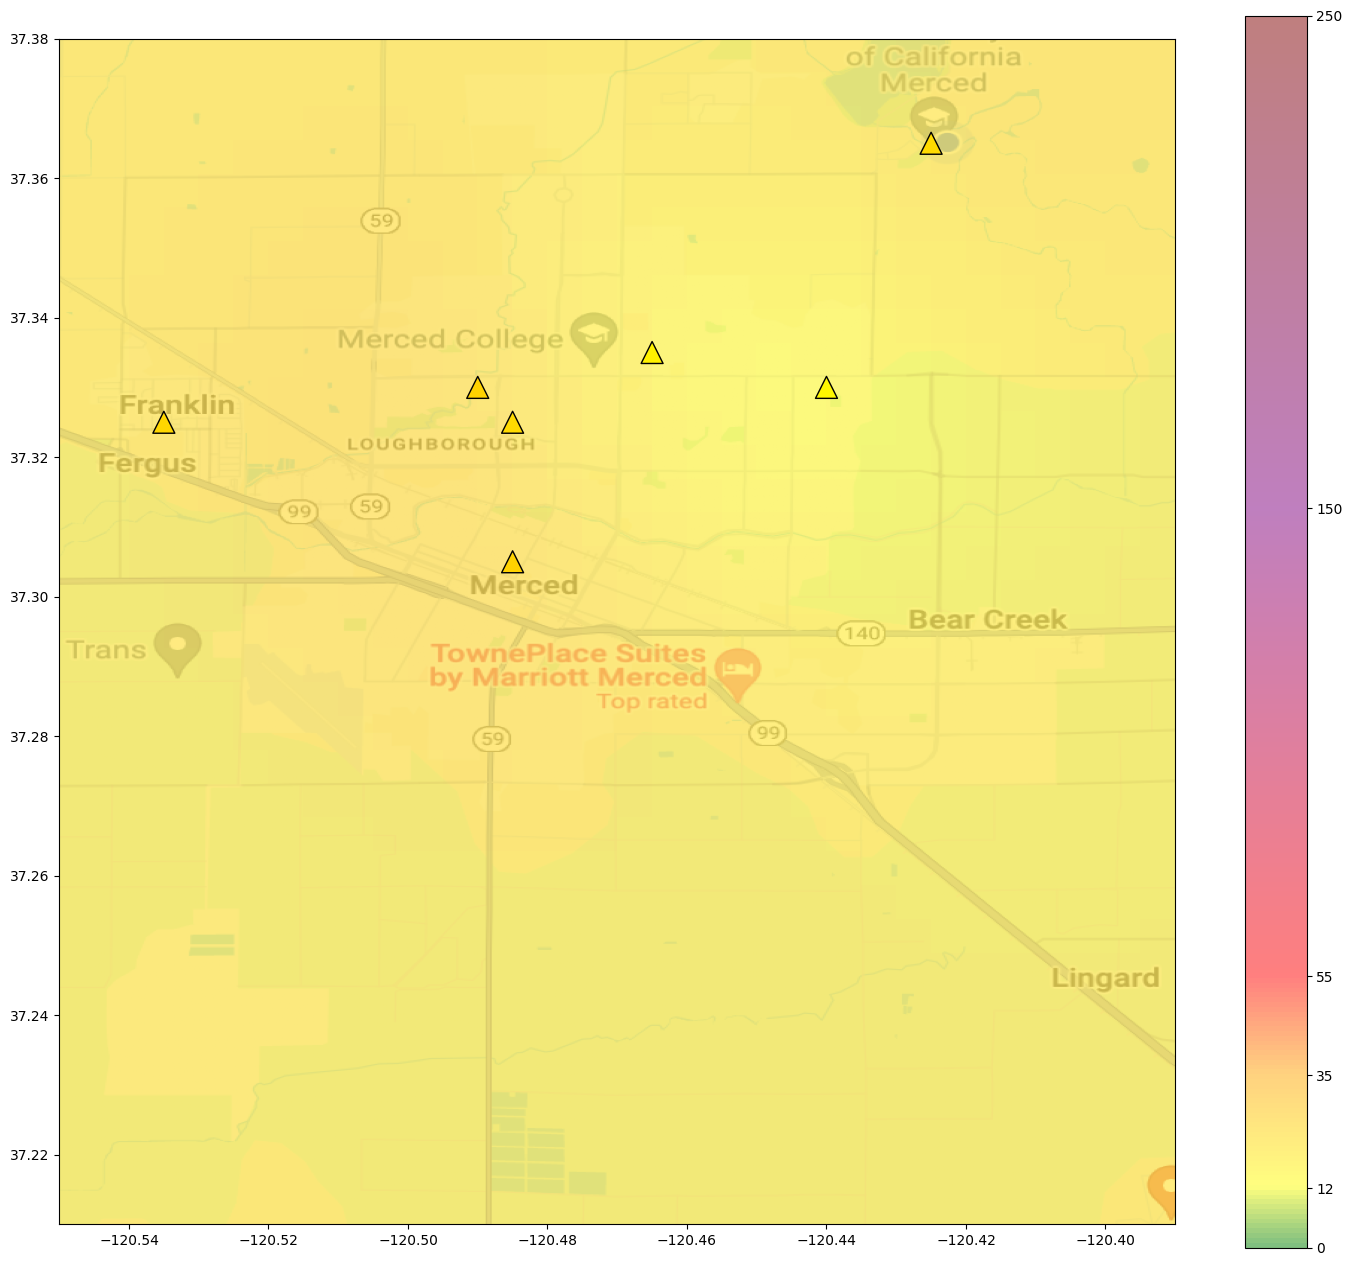

In [238]:
color_list = [(0, "green"), (12 / 250, "yellow"), (35 / 250, "orange"), (55 / 250, "red"), (150 / 250, "purple"), (1, "maroon")]
custom_cmap = mpl.colors.LinearSegmentedColormap.from_list("custom_cmap", color_list)

merced_map = plt.imread("./Merced_Map.png")

fig, ax = plt.subplots(figsize=(18, 16))
ax.grid(False)
extent = merced_boundary[0], merced_boundary[2], merced_boundary[3], merced_boundary[1]
plt.imshow(merced_map, alpha=0.5, extent=extent)
sc = plt.imshow(pred_y_mean, origin="lower", cmap=custom_cmap, vmin=0, vmax=250, alpha=0.5, extent=extent)
ax.scatter(train_x[:, 0], train_x[:, 1],
           c=train_y, cmap=custom_cmap,
           marker="^", s=250, edgecolors="black",
           vmin=0, vmax=250, alpha=1)
plt.colorbar(sc, ticks=[0, 12, 35, 55, 150, 250])
plt.show()

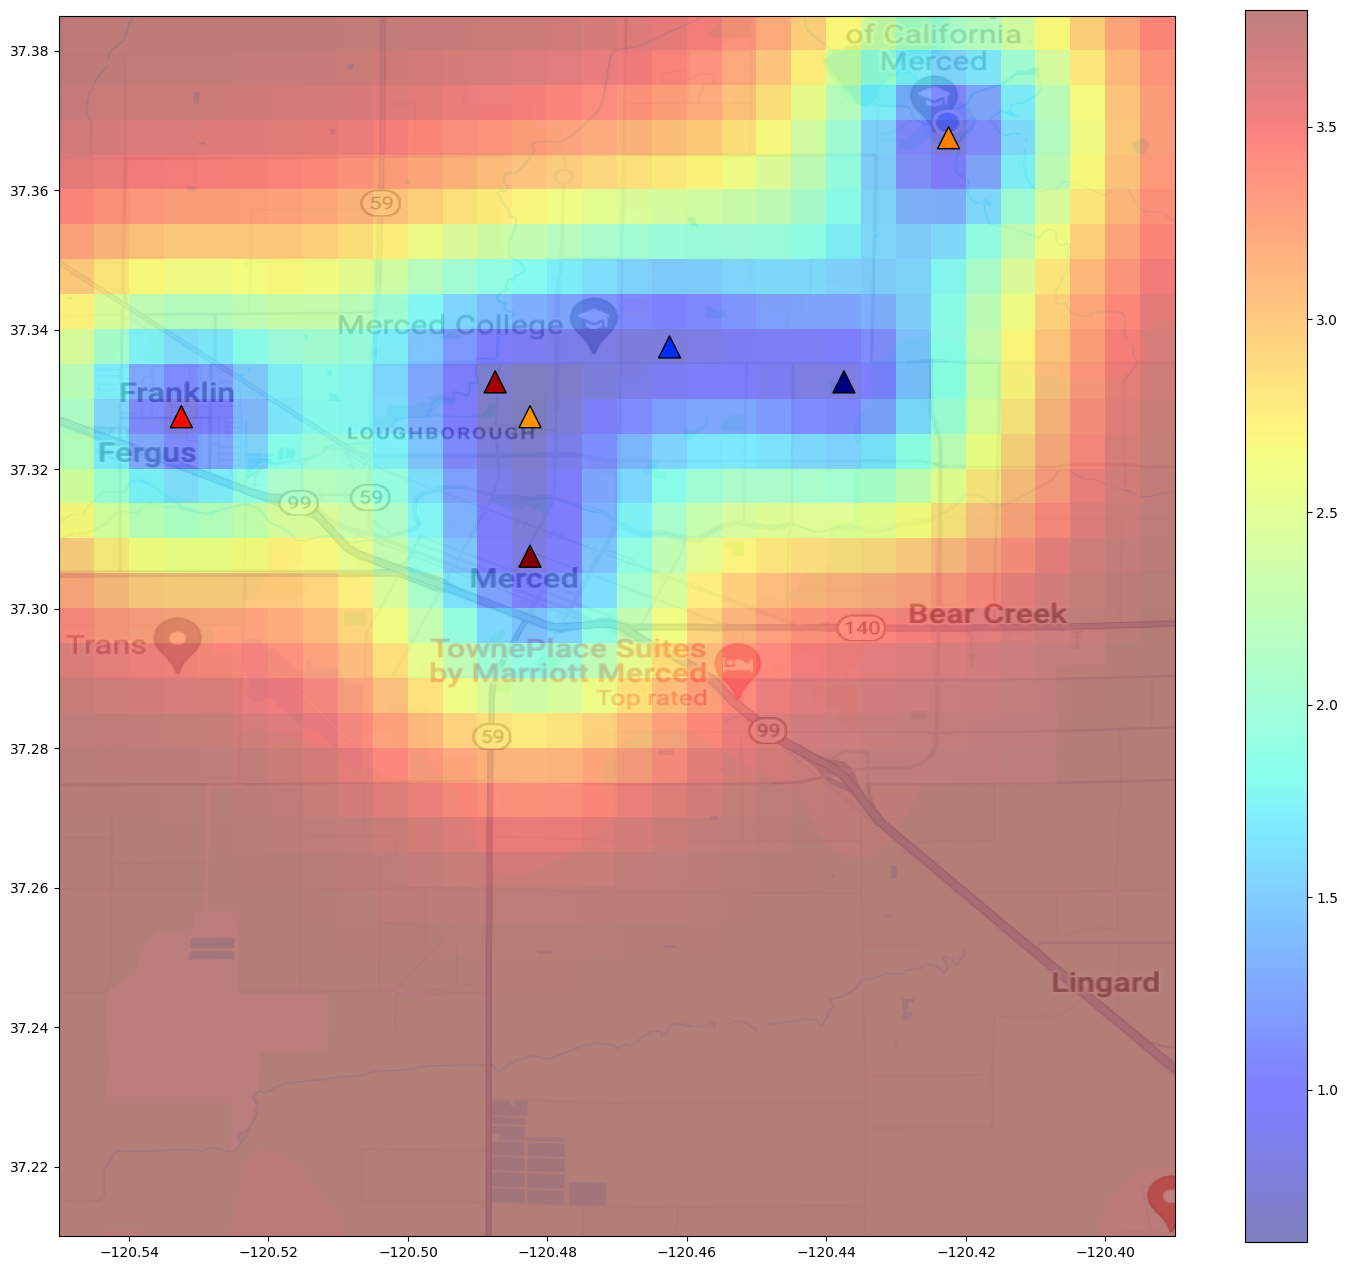

In [239]:
merced_map = plt.imread("./Merced_Map.png")

fig, ax = plt.subplots(figsize=(18, 16))
ax.grid(False)
extent = merced_boundary[0], merced_boundary[2], merced_boundary[3], merced_boundary[1]+h
plt.imshow(merced_map, alpha=0.5, extent=extent)
sc = plt.imshow(pred_y_std, origin="lower", cmap="jet", alpha=0.5, extent=extent)
ax.scatter(train_x[:, 0] + h/2, train_x[:, 1] + h/2,
           c=train_y, cmap="jet",
           marker="^", s=250, edgecolors="black",
           alpha=1)
plt.colorbar()
plt.show()

In [230]:
pred_y.mean

tensor([21.2133, 21.2136, 21.2147, 21.2190, 21.2326, 21.2698, 21.3551, 21.5177,
        21.7694, 22.0740, 22.3368, 22.4457, 22.3464, 22.0848, 21.7735, 21.5140,
        21.3480, 21.2637, 21.2134, 21.2140, 21.2165, 21.2249, 21.2497, 21.3107,
        21.4375, 21.6592, 21.9807, 22.3536, 22.6703, 22.8053, 22.6926, 22.3768,
        21.9849, 21.6435, 21.4145, 21.2921, 21.2136, 21.2149, 21.2199, 21.2366,
        21.2820, 21.3843, 21.5760, 21.8761, 22.2684, 22.6888, 23.0317, 23.1810,
        23.0668, 22.7169, 22.2531, 21.8212, 21.5120, 21.3361, 21.2139, 21.2162,
        21.2255, 21.2554, 21.3336, 21.5006, 21.7904, 22.2001, 22.6744, 23.1243,
        23.4588, 23.5967, 23.4777, 23.1034, 22.5724, 22.0421, 21.6375, 21.3944,
        21.2142, 21.2180, 21.2325, 21.2788, 21.3978, 21.6441, 22.0514, 22.5846,
        23.1318, 23.5680, 23.8264, 23.8903, 23.7383, 23.3535, 22.7949, 22.2083,
        21.7384, 21.4442, 21.2145, 21.2195, 21.2386, 21.2990, 21.4525, 21.7642,
        22.2619, 22.8707, 23.4141, 23.72